In [1]:
from FlowCytometryTools import FCPlate
from re import search

from pandas import DataFrame,Index
from sklearn import mixture

from numpy import array,arcsinh,unique,mean,dot,argmax
from numpy.random import choice

from scanpy import AnnData,settings,logging,settings
from scanpy.preprocessing import neighbors
from scanpy.tools import umap,leiden

from scanpy.plotting import stacked_violin
from scanpy.plotting import umap as plot_umap
from scanpy.plotting._tools.scatterplots import _get_data_points

from matplotlib.pyplot import plot,title,figure,subplot,figlegend,xticks,yticks
from matplotlib.pyplot import matshow,xlabel,ylabel,ylim,xlim,tight_layout,yscale
from seaborn import swarmplot,boxplot

# import scanpy as sc

settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
logging.print_versions()
settings.set_figure_params(dpi=80, facecolor='white')

################################################# helper functions
def parser(file_path) :
    
    tissue = search('_(.+?)_',file_path).group()
    if 'Blood' in tissue : tissue = '_Blood_'
    patient = search('/[0-9]+C/',file_path).group()

    return (tissue[1:-1],patient[1:-1])

/home/gszep/.local/lib/python3.6/site-packages/FlowCytometryTools/core/docstring.py:56: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  doc = dedent(doc)
/home/gszep/.local/lib/python3.6/site-packages/FlowCytometryTools/core/docstring.py:56: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  doc = dedent(doc)


scanpy==1.5.1 anndata==0.7.3 umap==0.4.3 numpy==1.18.4 scipy==1.4.1 pandas==1.0.4 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2 leidenalg==0.8.0


/home/gszep/.local/lib/python3.6/site-packages/umap/spectral.py:4: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  import numba.targets


In [2]:
################################################# define order of observations
patients = [ '390C', '423C', '428C', '412C', '403C' ]
tissues = [ 'Blood','Spleen','tLN','mLN','BM','Ileum','Lung','Liver']
markers = [
    'CD3','CD8','CD4','CD45RA','CCR7',      #top-level
    'CXCR3','CCR6','CCR4','CCR10','CXCR5',  #helper
    'CD127','CD25','Foxp3','Helios',        #regulatory
    'PD-1','CD69','CD103','HLA-DR'          #state
]

################################################# load fcs files
plate = FCPlate.from_dir(
    ID='TissueAtlas', path='./data/*/',  pattern='*.cleaned.fcs',
    
    parser=parser, position_mapper= lambda x: x,
    row_labels=tissues,col_labels=patients)

# standardise channel names across batches
channel_map = {
    'Foxp3-IgM': 'Foxp3', 
    'FJComp-355 379_28-A': 'CD3', 
    'FJComp-355 560_40-A': 'CD8', 
    'FJComp-355 740_35-A': 'CD69', 
    'FJComp-355 820_60-A': 'CD4', 
    'FJComp-405 450_50-A': 'CD103', 
    'FJComp-405 515_20-A': 'HLA-DR', 
    'FJComp-405 605_40-A': 'CCR4', 
    'FJComp-405 670_30-A': 'CCR6', 
    'FJComp-405 710_40-A': 'PD-1', 
    'FJComp-405 780_60-A': 'CD45RA', 
    'FJComp-488 525_50-A': 'CCR10', 
    'FJComp-488 715_30-A': 'CXCR3', 
    'FJComp-561 585_15-A': 'Foxp3', 
    'FJComp-561 610_20-A': 'Helios', 
    'FJComp-561 780_60-A': 'CD127', 
    'FJComp-640 670_30-A': 'CD25', 
    'FJComp-640 730_35-A': 'CXCR5', 
    'FJComp-640 780_60-A': 'CCR7'
}

for idx in plate :
    
    plate[idx].data = plate[idx].data.rename(columns=channel_map)
    plate[idx].data = plate[idx].data.reindex(columns=markers)
    plate[idx].meta['_channel_names_'] = tuple(markers)

################################################# apply biexponential transfromation
cofactor = 250.0
dataset = plate.transform( lambda x: arcsinh(x/cofactor) )

################################################# convert plate into scanpy object
others = []
for i,idx in enumerate(plate) :
    
    observations = DataFrame(index=dataset[idx].data.index, columns=['tissue','patient'])
    observations['tissue'],observations['patient'] = idx

    antigen = DataFrame(index=Index(dataset[idx].data.columns,name='index'), columns=['type'])
    antigen['type'] = None
    
    annotated_data = AnnData(dataset[idx].data,obs=observations,var=antigen)
    sample_size =  len(annotated_data)

    ################################################# uniform subsample of data
    subsample = 10000
    if subsample <= sample_size :
        annotated_data = annotated_data[choice(range(sample_size),size=subsample,replace=False)]

    if i == 1 :
        first = annotated_data
    else :
        others += [annotated_data]  
annotated_dataset = first.concatenate(others)

/home/gszep/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [3]:
################################################## estimate cutoffs between bimodal populations per channel
def estimate_cutoffs(data) :
    cutoffs = []
    for channel in data.T :
        
        gmm = mixture.GaussianMixture(
            n_components=2,covariance_type='spherical').fit(channel.reshape(-1, 1))

        assert gmm.converged_, "Gaussian Mixtures not converged"
        cutoff = sum(gmm.means_.flatten()*gmm.precisions_)/sum(gmm.precisions_)
        cutoffs.append(cutoff)
    
    return array(cutoffs)

annotated_dataset.X -= estimate_cutoffs(annotated_dataset.X)

In [4]:
%%capture
################################################# quality assurance check: dynamic range and cutoffs
violins = stacked_violin(annotated_dataset, markers, groupby='tissue',
    figsize=(10,20), swap_axes=True, scale='area');

... storing 'tissue' as categorical
... storing 'patient' as categorical
... storing 'type' as categorical


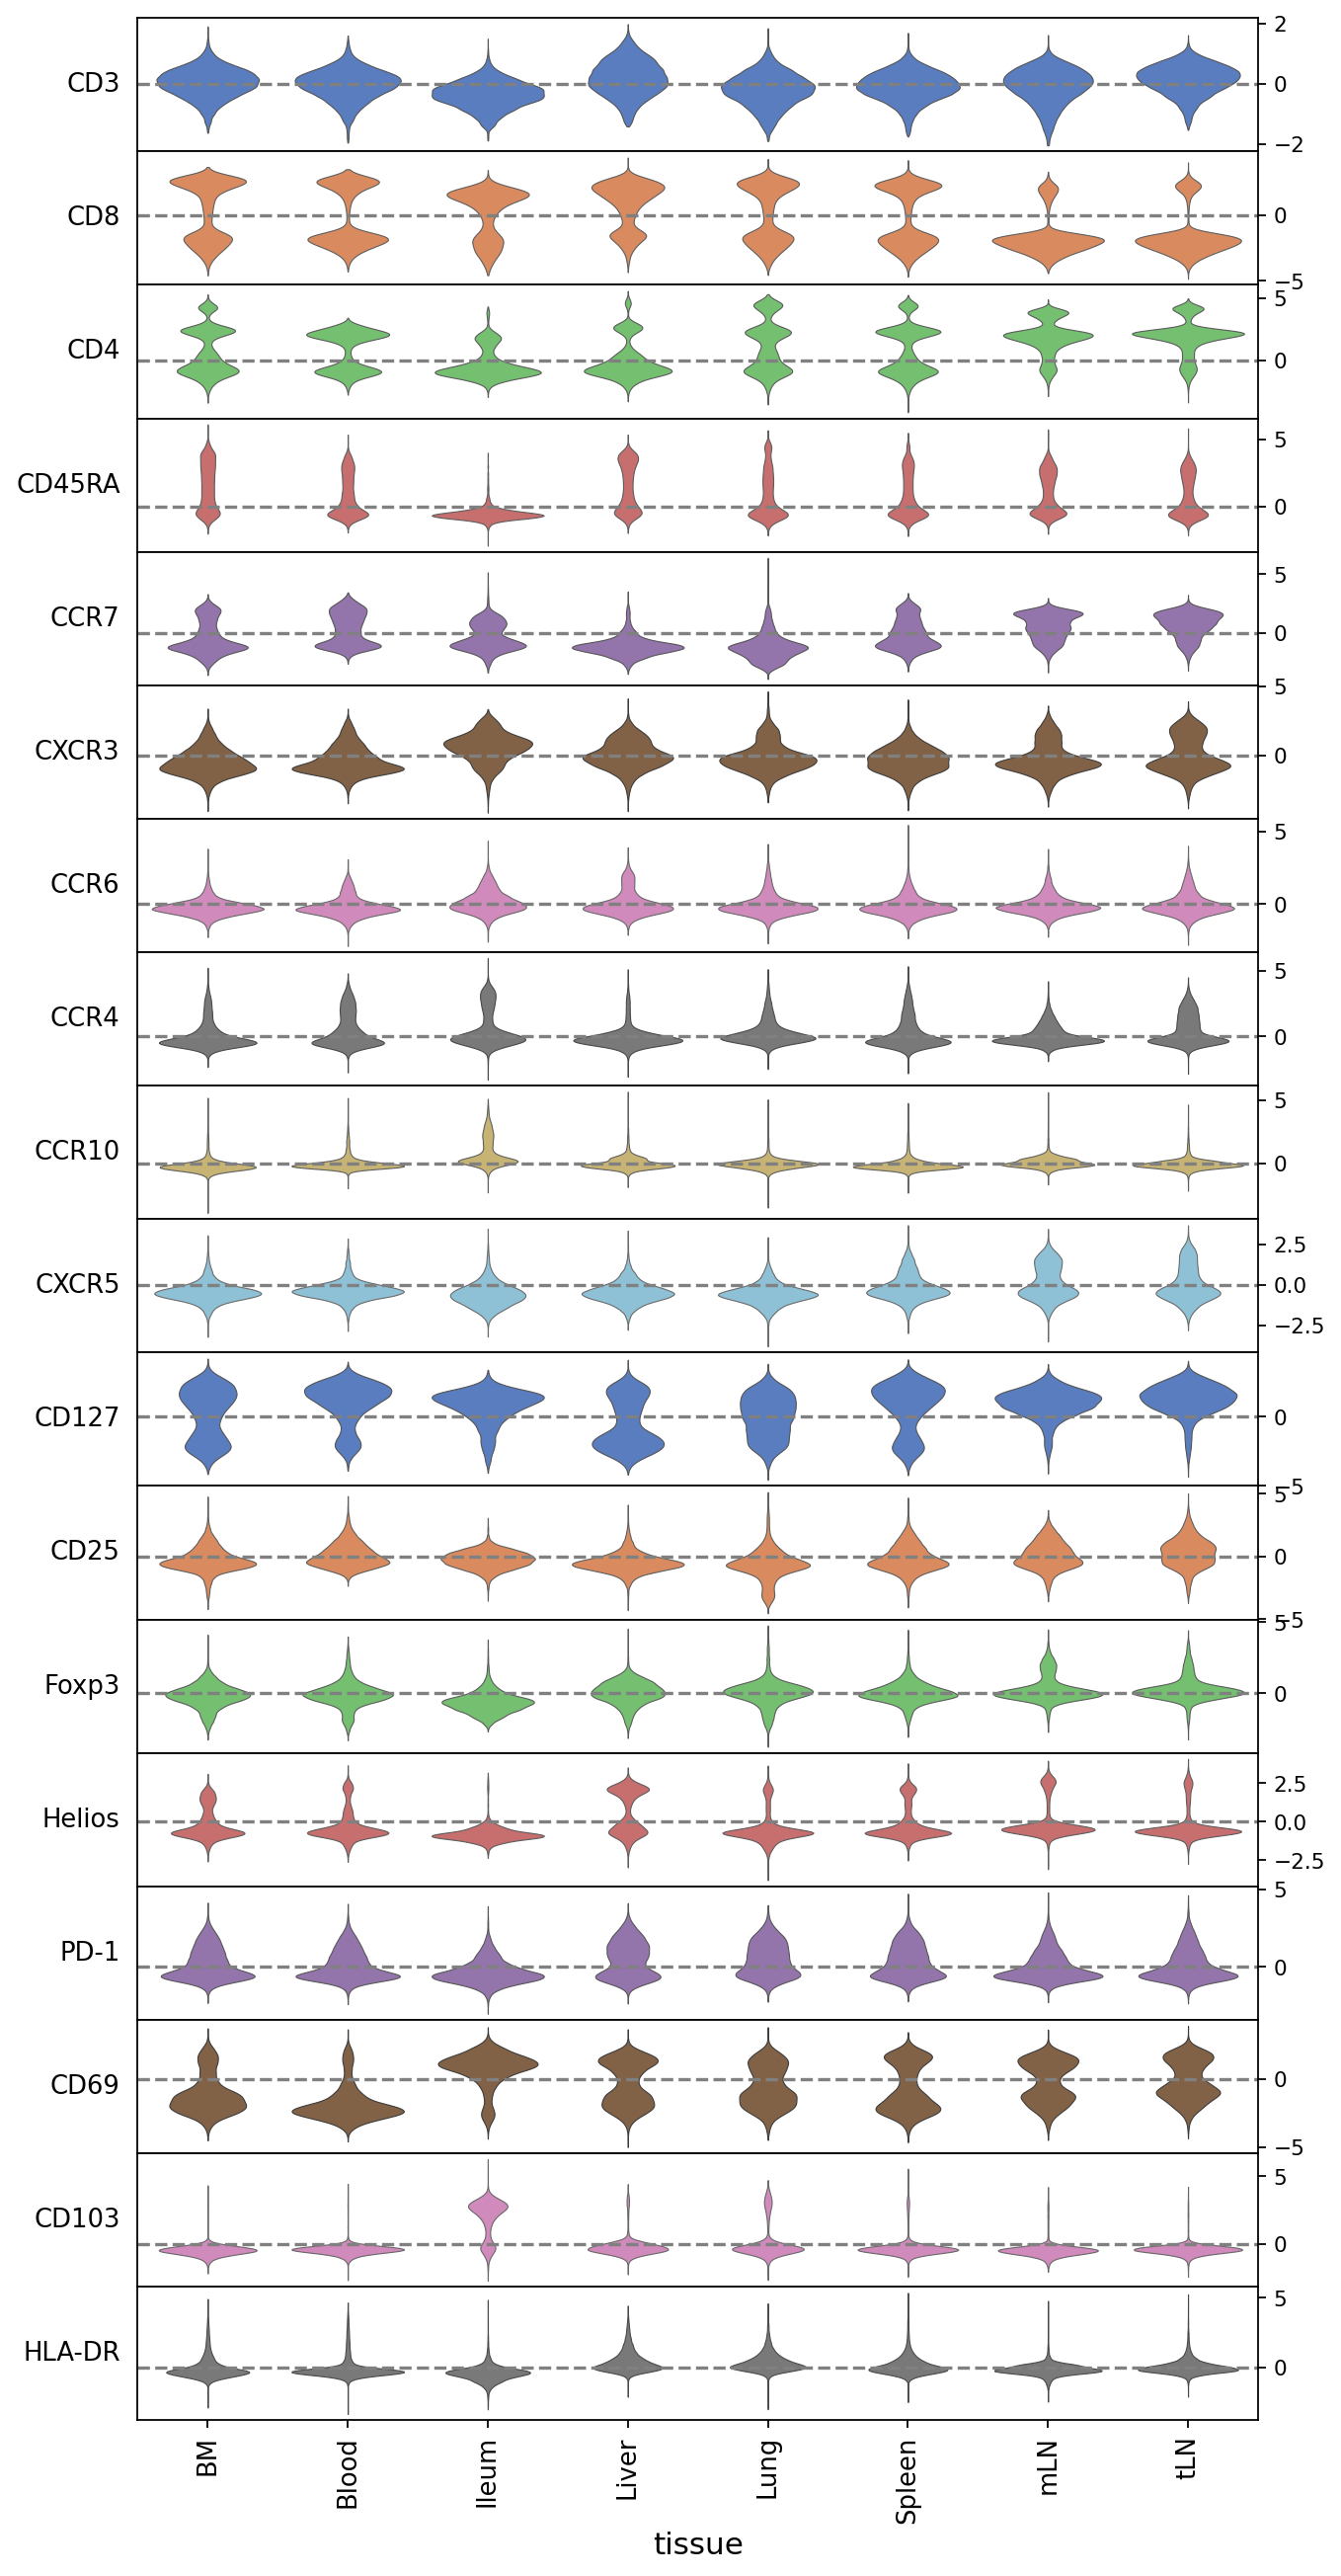

In [5]:
for ax in violins:
    ax.axhline(0,color='gray',linestyle='--')
violins[0].figure

In [ ]:
################################################# dimensionality reduction
neighbors(annotated_dataset, n_neighbors=10, n_pcs=40)
umap(annotated_dataset)

computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:06)
computing UMAP


In [ ]:
plot_umap(annotated_dataset, color=markers, ncols=5,color_map='RdYlGn')

In [ ]:
################################################# clustering
leiden(annotated_dataset)
plot_umap(annotated_dataset, color=['leiden'])

In [ ]:
%%capture
violins = stacked_violin(annotated_dataset, markers, groupby='leiden',
    figsize=(15,20), swap_axes=True, scale='area', dendrogram=True);

In [ ]:
for ax in violins:
    ax.axhline(0,color='gray',linestyle='--')
violins[0].figure

In [ ]:
profile_names = [
    'CD8+|Naive','CD8+|EM','CD8+|EMRA','CD8+|CM',
    'CD4+|Naive','CD4+|EM','CD4+|EMRA',
    'CD4+|Th1','CD4+|Th2','CD4+|Th17','CD4+|Th22',
    'CD4+|Tfh','CD4+|Treg',
    'CD4-|CD8-','Unmatched'
]

profile_matrix = array([
    [0,1,-1,1,1,    0,0,0,0,0,    0,0,0,0,    0,0,0,0], # CD8+|Naive
    [0,1,-1,-1,-1,  0,0,0,0,0,    0,0,0,0,    0,0,0,0], # CD8+|EM
    [0,1,-1,1,-1,   0,0,0,0,0,    0,0,0,0,    0,0,0,0], # CD8+|EMRA
    [0,1,-1,-1,1,   0,0,0,0,0,    0,0,0,0,    0,0,0,0], # CD8+|CM
    
    [0,-1,1,1,1,    0,0,0,0,0,    0,0,0,0,    0,0,0,0], # CD4+|Naive
    [0,-1,1,-1,-1,  0,0,0,0,0,    0,0,0,0,    0,0,0,0], # CD4+|EM
    [0,-1,1,1,-1,   0,0,0,0,0,    0,0,0,0,    0,0,0,0], # CD4+|EMRA
    
    [0,-1,1,-1,1,   1,0,0,0,0,    0,0,0,0,    0,0,0,0], # CD4+|Th1
    [0,-1,1,-1,1,  -1,-1,0,0,0,   0,0,0,0,    0,0,0,0], # CD4+|Th2
    [0,-1,1,-1,1,  -1,1,1,-1,0,   0,0,0,0,    0,0,0,0], # CD4+|Th17
    [0,-1,1,-1,1,  -1,1,1,1,0,    0,0,0,0,    0,0,0,0], # CD4+|Th22

    [0,-1,1,0,0,    0,0,0,0,1,    0,0,0,0,    1,0,0,0], # CD4+|Tfh
    [0,-1,1,0,0,    0,0,0,0,0,    0,1,1,1,    0,0,0,0], # CD4+|Treg

    [0,-1,-1,0,0,   0,0,0,0,0,    0,0,0,0,    0,0,0,0], # CD4-|CD8-
    [0,0,0,0,0,     0,0,0,0,0,    0,0,0,0,    0,0,0,0], # unmatched

])

def apply_labels(data, profile_matrix, profile_names, observation='label') :

    n_clusters = len(unique(data.obs.leiden.values))
    mapping_matrix = []

    for id in range(n_clusters):
        mapping_matrix += [mean(dot(data.X[data.obs.leiden == str(id)],profile_matrix.T),axis=0)]
        
    mapping_matrix = array(mapping_matrix).T
    matshow(mapping_matrix,cmap='bone_r')
    
    data.obs[observation] = 'Unmatched'
    for i,j in enumerate( argmax(mapping_matrix,axis=0)) :
        
        data.obs[observation][data.obs.leiden==str(i)] = profile_names[j]
        
apply_labels(annotated_dataset, profile_matrix, profile_names)
labels = annotated_dataset.obs.label.unique() 

In [ ]:
%%capture
violins = stacked_violin(annotated_dataset, markers, groupby='label',
    figsize=(10,20), swap_axes=True, scale='area');

In [ ]:
for ax in violins:
    ax.axhline(0,color='gray',linestyle='--')
violins[0].figure

In [ ]:
############################################################# dimensionally reduced per tissue and cluster
fig = figure(figsize=(15,8))
fig.suptitle('Uniform Manifold Approximation Projection',x=0.55,y=1.02)
[projection],_ = _get_data_points( annotated_dataset, 'umap', '2d', None, None, None )

for i,tissue in enumerate(tissues) :
    
    subplot(2,4,i+1)
    title(tissue,fontsize=16,y=1.02)

    lines = []
    for label in annotated_dataset.obs.label.unique() :
        mask = (annotated_dataset.obs.label==label)&(annotated_dataset.obs.tissue==tissue)
        
        points = projection[mask]
        line, = plot(points[:,0],points[:,1],'.',ms=1,label=label)

        xticks([], []); yticks([], [])
        lines += [line]
        
        
figlegend( lines, annotated_dataset.obs.label.unique(), loc = (0.1,0.01), ncol=6,
          fontsize=16, markerscale=10, frameon=False);

In [ ]:
############################################################# relative abundance
annotated_dataset.obs['abundance'] = 1
relative_abundance = ( 100*annotated_dataset.obs.groupby(['tissue','patient','label']).count() \
/ annotated_dataset.obs.groupby(['tissue','patient']).count()[['abundance']] ).reset_index()

fig = figure(figsize=(15,12))
fig.suptitle('Relative Population Abundance',x=0.55,y=1.02)

for i,label in enumerate(labels) :
    
    subplot(3,4,i+1)
    title(label,fontsize=16,y=1.02)
    mask = relative_abundance.label == label
    
    swarmplot(x="tissue", y="abundance",
                 data=relative_abundance[mask], palette="Set3")
    ax = boxplot(x="tissue", y="abundance",
                 data=relative_abundance[mask], palette="Set3")
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
    
    xlabel('Tissue',fontsize=16)
    ylabel('Percentage',fontsize=16)
    ylim(1e-2,1e2); yscale('log')

tight_layout()